### Personality and It's Transformations ###

An analysis of prof. Jordan Peterson's collection of lectures from University of Toronto personality course.

Lectures in video form provided at: https://www.youtube.com/playlist?list=PL22J3VaeABQAOhH1CLMNnMl2R-O1abW1T     |    More about prof. Peterson at https://www.jordanbpeterson.com/

---

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sentence_transformers import SentenceTransformer

from constants import *

import umap
import hdbscan
from collections import Counter
from tqdm import tqdm

import nltk
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Load the data</h4> 
</div>

In [2]:
with open(f'{OUTPUT_FOLDER}\{FINAL_CAPTIONS_FILE_NAME}', 'r', encoding='utf-8') as f:
    data = f.readlines()
data = [sent.replace('\n', '') for sent in data]

In [3]:
data[:5]

['Well, after all that.',
 'So, welcome to Psychology 230.',
 'Nice to see you all here.',
 'So, what I’m going to do today—how I’m going to start—is I’m going to give you an overview of the content of the course',
 'and then I’ll give you an overview of the class requirements right at the end.']

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Check the dataset</h4> 
</div>

In [4]:
NO_OF_SENTS = len(data)
NO_OF_SENTS

6144

There are 6144 sentences in total

In [5]:
LONGEST_SENTENCE = 315

Maximal number of words in a single sentence is 315 (information obtained from notebook 02). This is because oral lectures typically are chains of thoughts from the speaker and don't follow a syntactic structure typical for written information.

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Model implementation</h4> 
</div>

A paraphrase identification model was chosen because generally models like those are good at similarity and retrieval tasks.

In [6]:
model_name = 'paraphrase-distilroberta-base-v1'
model = SentenceTransformer(model_name)

The chooses model is a STS model that was trained on NLI Data and fine-tuned on a STS benchmark dataset. This means that the model is suitable for semantic similarity cases.

In [7]:
model.max_seq_length

128

The default model has length 128, but it must be increased because our longest sentence has 315 words and the number of tokens will be even greater. A max value of 512 will be set.

In [8]:
model.max_seq_length = SENT_LENGTH

In [9]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

This  model uses a mean pooling layer. Mean-pooling approach has the highest performences on NLI and STSb datasets.

Finally the model is a Roberta-based model which ensures better results over models like Bert and XLNet on  GLUE benchmatk since Roberta was trained on a larger dataset.

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Make basic embeddings</h4> 
</div>

In [10]:
%%time

embeddings = model.encode(data, batch_size=128, convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Wall time: 4min 30s


In [14]:
print(embeddings.shape, type(embeddings))
embeddings

(6144, 768) <class 'numpy.ndarray'>


array([[ 0.01237977,  0.2777765 , -0.01405313, ..., -0.02678866,
         0.04404815,  0.07773356],
       [ 0.04129101,  0.16136684,  0.02991311, ...,  0.58379793,
         0.14942269,  0.06346932],
       [-0.07501772,  0.4233094 , -0.0145095 , ...,  0.33547857,
         0.41762486, -0.00107458],
       ...,
       [ 0.00656719,  0.14959459,  0.08193731, ...,  0.16275299,
         0.10600478,  0.02682212],
       [ 0.40873346, -0.28501287,  1.0132743 , ...,  0.09641485,
         0.09259868, -0.08356816],
       [ 0.40873346, -0.28501287,  1.0132743 , ...,  0.09641485,
         0.09259868, -0.08356816]], dtype=float32)

### Saving the model ###

In [33]:
with open(f'{MODELS_FOLDER}\{model_name}.npy', 'wb') as f:
    np.save(f, embeddings)

### Loading the model ###

In [11]:
# with open(f'{MODELS_FOLDER}\{SAMPLE_EMBEDDINGS_MODEL_NAME}.npy', 'rb') as f:
#     embeddings = np.load(f)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Dimensionality reduction</h4> 
</div>

***UMAP*** for a dimensionality reduction.

In [15]:
neighbors = 20
components = 10

`n_neighbors` regulates whether UMAP should focus more on global or lobal scructures of the data. Low values of n_neighbors will force UMAP to concentrate on very local structure (it will find patterns in local small sections not seeing the big picture), while large values will push UMAP to look at larger neighborhoods (focusing on the big picture) losing fine distinct features of local, smaller neighborhoods. You can think of this like literally focusing on your neighbors when you live for example on a country side. If n_neighbors is small someone can describe you  based on your membership to only your small community (e.g. people from your street). If n_neighbors is large someone can describe you based on the judgement from people from the whole city or state.

`n_components` the dimensionality of the reduced dimension space we will be embedding the data into.

We will be trying to reduce 768 dimmentions to 10

### Training the sample model ###

In [16]:
%%time

umap_embeddings = umap.UMAP(
    n_neighbors = neighbors,
    n_components = components,
    n_epochs = 4000,
    min_dist = 0.0,
    learning_rate = 0.4,
    verbose = True,
    metric = 'cosine').fit_transform(embeddings)

UMAP(angular_rp_forest=True, learning_rate=0.4, metric='cosine', min_dist=0.0, n_components=10, n_epochs=4000, n_neighbors=20, verbose=True)
Thu Apr 27 20:46:33 2023 Construct fuzzy simplicial set
Thu Apr 27 20:46:33 2023 Finding Nearest Neighbors
Thu Apr 27 20:46:33 2023 Building RP forest with 9 trees
Thu Apr 27 20:46:34 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Thu Apr 27 20:46:51 2023 Finished Nearest Neighbor Search
Thu Apr 27 20:46:54 2023 Construct embedding


Epochs completed:   0%|            0/4000 [00:00]

Thu Apr 27 20:47:58 2023 Finished embedding
Wall time: 1min 25s


In [17]:
print(umap_embeddings.shape, type(umap_embeddings))
umap_embeddings

(6144, 10) <class 'numpy.ndarray'>


array([[ 5.309515 , -7.4352345, -2.4204338, ...,  4.3864894,  1.9958822,
         6.0253406],
       [ 5.5786185, -7.5089545, -2.326396 , ...,  4.4433   ,  2.3535326,
         6.0981402],
       [ 5.52746  , -7.4649343, -2.307622 , ...,  4.469943 ,  2.363957 ,
         6.0803213],
       ...,
       [ 4.8542175, -7.4570246, -2.6268246, ...,  4.4466662,  1.7981771,
         6.237587 ],
       [ 7.306242 , -8.090295 , -1.9546282, ...,  4.0447383,  3.4701455,
         6.6279483],
       [ 7.305469 , -8.090206 , -1.954521 , ...,  4.044511 ,  3.4698365,
         6.6279206]], dtype=float32)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Clustering</h4> 
</div>

***HDBSCAN*** is a hierarchical clustering algorithm. 

In [18]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [19]:
min_cluser_size = 80
min_samples = 2

`min_cluster_size` - the minimum size a final cluster can be.   
`min_samples` - the higher this is, the more points are going to be treeted as outliers.

In [20]:
%%time

clusters = hdbscan.HDBSCAN(
    min_cluster_size = min_cluser_size,
    metric = 'euclidean',
    min_samples = min_samples,
    cluster_selection_epsilon = 0.1,
    cluster_selection_method = 'leaf',
    leaf_size = 35,
    algorithm = 'best').fit(umap_embeddings)


Wall time: 420 ms


In [21]:
def cluster_statistics(clusters:hdbscan.hdbscan_.HDBSCAN, 
compact : bool = False) -> pd.DataFrame:
    """Print basic statistic about a given structure of clusters
        - number of unique clusters
        - number of all points
        - number of points treeted as outliers (noise)
        This also plots distribution of the clusters

    Args:
        clusters (hdbscan.hdbscan_.HDBSCAN): HDBSCAN clusters 
        compact (bool): if True only two values (number of clusters and 
        percentage of noise) will be outputed

    Returns:
        pd.DataFrame: a dataframe with basic statistics
        Additionaly a plot of cluster distribution in shown.
    """

    # empty dataframe
    summary = pd.DataFrame(columns = ['metric', 'value'])
    summary.at[0, 'metric'] = 'Number of unique clusters'

    # get number of all clusters in first row
    summary.at[0, 'value'] = len(set(clusters.labels_))

    # count number of points in each cluster (sentences in each group)
    cnt = Counter()
    cnt.update(clusters.labels_)

    # total number of all sentences
    sum_of_all_elements = sum([entry[1] for entry in cnt.most_common()])
    # number of outlier sentences
    sum_of_empty_elements = [entry[1] for entry in cnt.most_common() if entry[0] == -1][0]

    # get total number of all sentences and number of outliers into the dataframe
    summary.at[1, 'metric'] = 'Number of all sentences'
    summary.at[1, 'value'] = sum_of_all_elements
    
    summary.at[2, 'metric'] = 'Number of noise'

    # calculate how many percent of total sentences are the outlier sentences
    percentage = '{:.4}'.format(str((sum_of_empty_elements/sum_of_all_elements)*100))
    summary.at[2, 'value'] = f'{sum_of_empty_elements} ({percentage}%)'

    # get points for the distribution showing number of sentences in each cluster
    x, y= zip(*cnt.most_common())

    # output plot and dataframe as summay
    if compact != True:
        plt.bar(x, y);
        return summary

    # output only number of clusters and percentage of noise
    else:
        return len(set(clusters.labels_)), sum_of_empty_elements/sum_of_all_elements

,metric,value
0,Number of unique clusters,23
1,Number of all sentences,6144
2,Number of noise,2153 (35.0%)


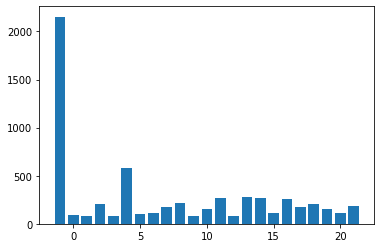

In [22]:
cluster_statistics(clusters)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Cluster analysis</h4> 
</div>

In [23]:
final_data = pd.DataFrame(data, columns=['text'])
final_data['cluster_ids'] = clusters.labels_

In [24]:
final_data

,text,cluster_ids
0,"Well, after all that.",19
1,"So, welcome to Psychology 230.",10
2,Nice to see you all here.,10
3,"So, what I’m going to do today—how I’m going t...",0
4,and then I’ll give you an overview of the clas...,0
...,...,...
6139,And if you're on the low end of the IQ distrib...,16
6140,"It has nothing to do with willingness to work,...",-1
6141,"And it's a good thing to know, even though it'...",18
6142,,-1


In [25]:
emb = final_data.groupby(['cluster_ids'], as_index=False).agg({'text': ' '.join})
emb

,cluster_ids,text
0,-1,"So, there’s a website—I don’t really like Blac..."
1,0,"So, what I’m going to do today—how I’m going t..."
2,1,So the first issue is that there’s a lot of re...
3,2,But I think we might as well jump right into t...
4,3,So when we’re first born—we’re very primitive ...
5,4,And so in the mirror test what you essentially...
6,5,"Now, dolphins seem to be able to manage that, ..."
7,6,"Now, part of the reason for that is that Nietz..."
8,7,"It brings in elements of cultural history, ele..."
9,8,Most of the brain is structured with the olfac...


In [26]:
emb.to_csv(f'{OUTPUT_FOLDER}\{CLUSTERED_TOPICS_DATAFRAME_NAME}.csv')

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Visualisation</h4> 
</div>

Data needs to be reduced to 3 dimmentions for visualisation

In [27]:
%%time

umap_3d = umap.UMAP(
    n_neighbors = neighbors,
    n_components = 3,
    min_dist = 0.5,
    n_epochs = 8000,
    learning_rate = 0.4,
    metric = 'cosine').fit_transform(embeddings)

Wall time: 2min 4s


Show all reduced representations

In [28]:
umap_3d

array([[-22.177742 ,   2.6684744, -25.425438 ],
       [-21.686144 ,   2.6634564, -26.239578 ],
       [-21.91546  ,   2.6650484, -25.492054 ],
       ...,
       [-22.761772 ,   1.1212133, -25.854843 ],
       [-19.243832 ,   2.9513304, -25.185356 ],
       [-19.228128 ,   3.0020514, -25.138441 ]], dtype=float32)

In [31]:
cluster_list = list(clusters.labels_)
cluster_list[:5]

[19, 10, 10, 0, 0]

In [29]:
umap_3d.shape

(6144, 3)

In [45]:
cluster_3d_df = pd.DataFrame(np.insert(umap_3d, 3, cluster_list, axis=1), columns=['x', 'y', 'z', 'cluster'])
cluster_3d_df

,x,y,z,cluster
0,-22.177742,2.668474,-25.425438,19.0
1,-21.686144,2.663456,-26.239578,10.0
2,-21.915461,2.665048,-25.492054,10.0
3,-23.566740,1.596187,-29.177954,0.0
4,-23.172817,1.649989,-29.177980,0.0
...,...,...,...,...
6139,-21.904552,-1.008725,-28.963610,16.0
6140,-23.402288,-0.104359,-25.331230,-1.0
6141,-22.761772,1.121213,-25.854843,18.0
6142,-19.243832,2.951330,-25.185356,-1.0


Simple plot

In [51]:
fig = px.scatter_3d(cluster_3d_df, x = 'x', y = 'y', z = 'z', color='cluster')

In [52]:
fig.show()

---